In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import sys
import glob
import re
import pickle
import random

import wave
import librosa as lb
import librosa.display as lbd
from python_speech_features import *
import soundfile as sf
import io
from IPython.display import Audio

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, Attention, LayerNormalization, Concatenate
import warnings
warnings.filterwarnings('ignore')

import csv
import parselmouth

# Data Preprocessing

In [34]:
data_csv_path = '/home/smrutibiswal/Research/Dataset/labels/edited'

train_df = pd.read_csv(os.path.join(data_csv_path, 'train_split.csv'))
train_df = train_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]

test_df = pd.read_csv(os.path.join(data_csv_path, 'dev_split.csv'))
test_df = test_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]

print(f"Train set: {train_df.shape[0]} samples, Test set: {test_df.shape[0]} samples")
print("Training Samples: ")
print(train_df.head())
print("Testing Samples: ")
print(test_df.head())

Train set: 148 samples, Test set: 48 samples
Training Samples: 
   Participant_ID   Gender  PHQ_Binary  PHQ_Score
0             302     male           0          4
1             303   female           0          0
2             304   female           0          6
3             305     male           0          7
4             307  female            0          4
Testing Samples: 
   Participant_ID  Gender  PHQ_Binary  PHQ_Score
0             300    male           0          2
1             301    male           0          3
2             306  female           0          0
3             317    male           0          8
4             320  female           0         11


In [35]:
train_audio_path = '/home/smrutibiswal/Research/Dataset/data/train/audios'
test_audio_path = '/home/smrutibiswal/Research/Dataset/data/validation/audios'
train_trans_path = '/home/smrutibiswal/Research/Dataset/data/train/transcripts'
test_trans_path = '/home/smrutibiswal/Research/Dataset/data/validation/transcripts'
train_txt_path = '/home/smrutibiswal/Research/TextOnly/train'
test_txt_path = '/home/smrutibiswal/Research/TextOnly/test'

train_df['Audio_Path'] = ''
train_df['Transcript_Path'] = ''
train_df['Text_Path'] = ''
test_df['Audio_Path'] = ''
test_df['Transcript_Path'] = ''
test_df['Text_Path'] = ''


for i in range(train_df.shape[0]):
    audio_file = str(train_df['Participant_ID'][i]) + '_AUDIO.wav'
    train_df['Audio_Path'][i] = os.path.join(train_audio_path, audio_file)
    transcript_file = str(train_df['Participant_ID'][i])+'_TRANSCRIPT.csv'
    train_df['Transcript_Path'][i] = os.path.join(train_trans_path, transcript_file)
    txt_file = str(train_df['Participant_ID'][i])+'.txt'
    train_df['Text_Path'][i] = os.path.join(train_txt_path, txt_file)
    
    
for i in range(len(test_df)):
    audio_file = str(test_df['Participant_ID'][i]) + '_AUDIO.wav'
    test_df['Audio_Path'][i] = os.path.join(test_audio_path, audio_file)
    transcript_file = str(test_df['Participant_ID'][i])+'_TRANSCRIPT.csv'
    test_df['Transcript_Path'][i] = os.path.join(test_trans_path, transcript_file)
    txt_file = str(test_df['Participant_ID'][i])+'.txt'
    test_df['Text_Path'][i] = os.path.join(test_txt_path, txt_file)
    
train_df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path
0,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...
1,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...
2,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...
3,305,male,0,7,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/305...
4,307,female,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/307...


In [36]:
train_df['Text'] = ''
train_conv_txt_path = '/home/smrutibiswal/Research/TextOnly/train'

for i in range(len(train_df)):
    file_name = str(train_df['Participant_ID'][i]) + '.txt'
    with open(os.path.join(train_conv_txt_path, file_name), 'r') as f:
        text = f.read()
        train_df['Text'][i] = text
        
train_df.head()

test_df['Text'] = ''
test_conv_txt_path = '/home/smrutibiswal/Research/TextOnly/test'

for i in range(len(test_df)):
    file_name = str(test_df['Participant_ID'][i]) + '.txt'
    with open(os.path.join(test_conv_txt_path, file_name), 'r') as f:
        text = f.read()
        test_df['Text'][i] = text
        
test_df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path,Text
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/300.txt,so I'm going to interview in Spanish okay g...
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/301.txt,yeah there's also on Craigslist so that's why ...
2,306,female,0,0,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/306.txt,okay looks like we're good. Let's move around ...
3,317,male,0,8,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/317.txt,equipment okay how was okay thanks are you ...
4,320,female,0,11,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/320.txt,perfect okay and okay and then I will let you...


In [37]:
df = pd.concat([train_df, test_df], axis=0)
df = df.sort_values(by=['Participant_ID'])
df = df.reset_index(drop=True)
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path,Text
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/300.txt,so I'm going to interview in Spanish okay g...
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/301.txt,yeah there's also on Craigslist so that's why ...
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...,just move around a little bit when you're fin...
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...,wow okay when you're finished when she's done...
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...,so we'll just move around a little bit tonight...


In [ ]:
audio_features_path = '/home/smrutibiswal/Research/SpeechOnly/features'

df['Audio_Features'] = ''

for i in range(len(df)):
    idx = df['Participant_ID'][i]
    feature_file = os.path.join(audio_features_path, str(idx) + '_features.pkl')
    if os.path.exists(feature_file):
        with open(feature_file, 'rb') as f:
            features = pickle.load(f)
        df['Audio_Features'][i] = features
    else:
        print(f"Feature file not found for Participant_ID: {idx}")
        
df.head()

    

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path,Text,Audio_Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/300.txt,so I'm going to interview in Spanish okay g...,"[[[0.45782435, -0.16789621, -0.42220274, -0.10..."
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/301.txt,yeah there's also on Craigslist so that's why ...,"[[[-0.7448366, 0.15698695, 0.042065322, -0.233..."
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...,just move around a little bit when you're fin...,"[[[-0.083217114, 0.5004096, 0.19636308, -0.082..."
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...,wow okay when you're finished when she's done...,"[[[-0.10374418, 0.43084466, 0.035689726, 0.181..."
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...,so we'll just move around a little bit tonight...,"[[[0.33124432, -0.22978759, 0.22174521, -0.378..."


# Data Imbalance

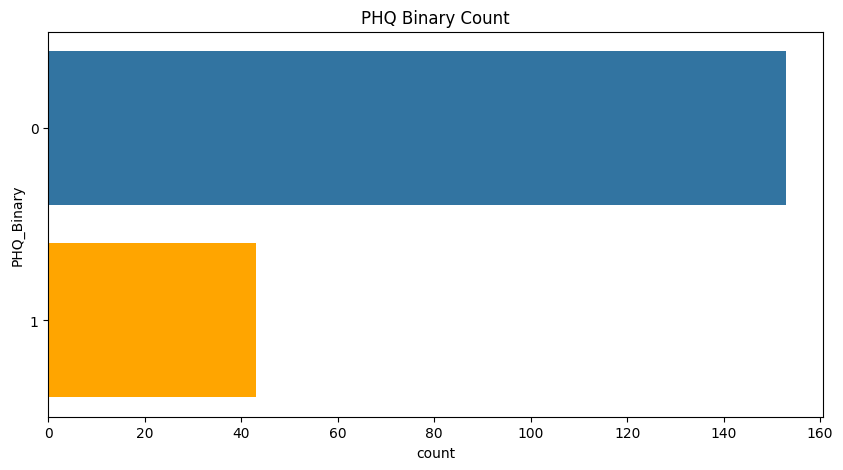

In [39]:
plt.figure(figsize=(10, 5))
sns.countplot(y='PHQ_Binary', data=df)
plt.gca().patches[1].set_facecolor('orange')
plt.title('PHQ Binary Count')
plt.show()

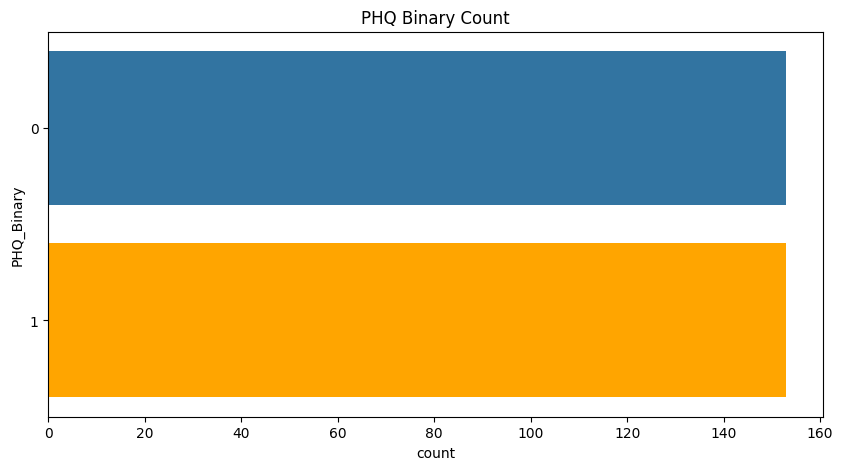

In [40]:
depressed = df[df['PHQ_Binary'] == 1]
not_depressed = df[df['PHQ_Binary'] == 0]

# not_depressed = not_depressed.sample(n=len(depressed), random_state=44)
depressed = depressed.sample(n=len(not_depressed), random_state=44, replace=True)

df = pd.concat([depressed, not_depressed], axis=0).reset_index(drop=True)
df = df.sample(frac=1, random_state=44).reset_index(drop=True)

plt.figure(figsize=(10, 5))
sns.countplot(y='PHQ_Binary', data=df)
plt.gca().patches[1].set_facecolor('orange')
plt.title('PHQ Binary Count')
plt.show()


In [41]:
# sort by Participant_ID
df = df.sort_values(by='Participant_ID')
df = df.reset_index(drop=True)

df.head()


,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path,Text,Audio_Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/300.txt,so I'm going to interview in Spanish okay g...,"[[[0.45782435, -0.16789621, -0.42220274, -0.10..."
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/301.txt,yeah there's also on Craigslist so that's why ...,"[[[-0.7448366, 0.15698695, 0.042065322, -0.233..."
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...,just move around a little bit when you're fin...,"[[[-0.083217114, 0.5004096, 0.19636308, -0.082..."
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...,wow okay when you're finished when she's done...,"[[[-0.10374418, 0.43084466, 0.035689726, 0.181..."
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...,so we'll just move around a little bit tonight...,"[[[0.33124432, -0.22978759, 0.22174521, -0.378..."


In [42]:
print(f"Final Dataset: {df.shape[0]} samples")

Final Dataset: 306 samples


# Text Modeling

## Train Test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['PHQ_Binary'], test_size=0.2, random_state=44)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_text = X_train

(244,) (62,) (244,) (62,)


## Tokenization

In [44]:
def count_num_words(text):
    """
    Count the number of words in a text.

    Args:
        text (str): The text to count the number of words in.

    Returns:
        int: The number of words in the text.
    """
    return len(text.split())

df['Text_length'] = df['Text'].apply(count_num_words)
df.head()

# find min and max text length
print(df['Text_length'].min())
print(df['Text_length'].max())

average = df['Text_length'].mean()
print(average)

max_len = int(average)
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'
vocab_size = 100000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
total_words = len(word_index) + 1

total_words


244
4611
1440.6176470588234


8245

In [45]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

print('Shape of training padded:', training_padded.shape)
print('Shape of testing padded:', testing_padded.shape)

Shape of training padded: (244, 1440)
Shape of testing padded: (62, 1440)


## Model Building

In [46]:
# define parameters
vocab_size = total_words
embedding_dim = 16
drop_value = 0.2
n_lstm = 128               # number of hidden units in BiLSTM
drop = 0.5
max_len = df['Text_length'].max()

In [47]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model_bilstm.add(Bidirectional(LSTM(n_lstm, return_sequences=False)))
model_bilstm.add(Dropout(drop))
model_bilstm.add(Dense(1, activation='sigmoid'))

model_bilstm.build(input_shape=(None, max_len))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_bilstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 4611, 16)       │       131,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,657 (1.07 MB)

 Trainable params: 280,657 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 - 27s - 3s/step - accuracy: 0.4590 - loss: 0.6952 - val_accuracy: 0.5161 - val_loss: 0.6918
Epoch 2/10
8/8 - 22s - 3s/step - accuracy: 0.5943 - loss: 0.6913 - val_accuracy: 0.5645 - val_loss: 0.6911
Epoch 3/10
8/8 - 22s - 3s/step - accuracy: 0.6311 - loss: 0.6875 - val_accuracy: 0.4839 - val_loss: 0.6884
Epoch 4/10
8/8 - 18s - 2s/step - accuracy: 0.7295 - loss: 0.6762 - val_accuracy: 0.6774 - val_loss: 0.6696
Epoch 5/10
8/8 - 21s - 3s/step - accuracy: 0.8074 - loss: 0.6364 - val_accuracy: 0.7742 - val_loss: 0.6168
Epoch 6/10
8/8 - 22s - 3s/step - accuracy: 0.7787 - loss: 0.6389 - val_accuracy: 0.7581 - val_loss: 0.5211
Epoch 7/10
8/8 - 22s - 3s/step - accuracy: 0.7992 - loss: 0.5238 - val_accuracy: 0.6129 - val_loss: 0.6471
Epoch 8/10
8/8 - 22s - 3s/step - accuracy: 0.8238 - loss: 0.5370 - val_accuracy: 0.7581 - val_loss: 0.5765
Epoch 9/10
8/8 - 22s - 3s/step - accuracy: 0.8852 - loss: 0.4086 - val_accuracy: 0.8387 - val_loss: 0.4540
Epoch 10/10
8/8 - 21s - 3s/step - acc

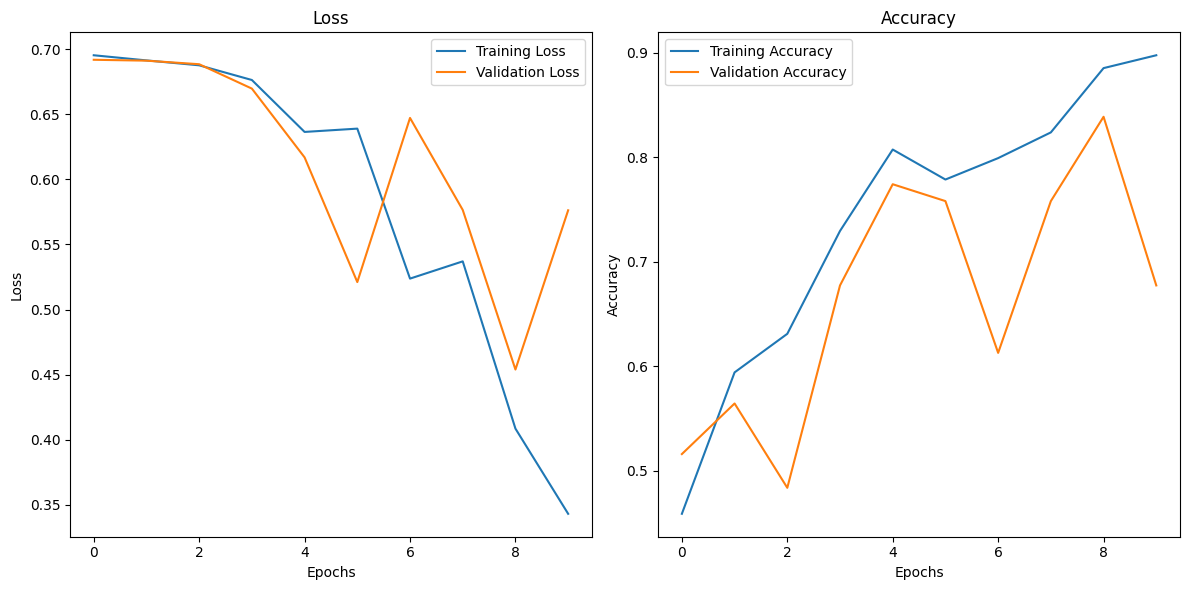

In [48]:
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model_bilstm.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)


# Plotting training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model_bilstm.add(Bidirectional(LSTM(n_lstm, return_sequences=False)))
model_bilstm.add(Dropout(drop))
model_bilstm.add(Dense(2, activation='softmax'))  # Output changed to 2 units

model_bilstm.build(input_shape=(None, max_len))
model_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Changed loss

model_bilstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 4611, 16)       │       131,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 256)            │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,914 (1.07 MB)

 Trainable params: 280,914 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Convert labels to categorical
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test) 

In [51]:
# Train the model with categorical labels
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model_bilstm.fit(training_padded, y_train_categorical, epochs=num_epochs, validation_data=(testing_padded, y_test_categorical), callbacks=[early_stop], verbose=2)

Epoch 1/10


8/8 - 27s - 3s/step - accuracy: 0.4877 - loss: 0.6930 - val_accuracy: 0.4839 - val_loss: 0.6928
Epoch 2/10
8/8 - 21s - 3s/step - accuracy: 0.5533 - loss: 0.6905 - val_accuracy: 0.6935 - val_loss: 0.6889
Epoch 3/10
8/8 - 20s - 3s/step - accuracy: 0.5779 - loss: 0.6848 - val_accuracy: 0.5000 - val_loss: 0.6816
Epoch 4/10
8/8 - 21s - 3s/step - accuracy: 0.7582 - loss: 0.6315 - val_accuracy: 0.6774 - val_loss: 0.6145
Epoch 5/10
8/8 - 20s - 3s/step - accuracy: 0.5369 - loss: 2.0026 - val_accuracy: 0.4839 - val_loss: 1.6291
Epoch 6/10
8/8 - 21s - 3s/step - accuracy: 0.4836 - loss: 0.9963 - val_accuracy: 0.5161 - val_loss: 0.7421
Epoch 7/10
8/8 - 21s - 3s/step - accuracy: 0.4795 - loss: 0.7527 - val_accuracy: 0.4839 - val_loss: 0.7220


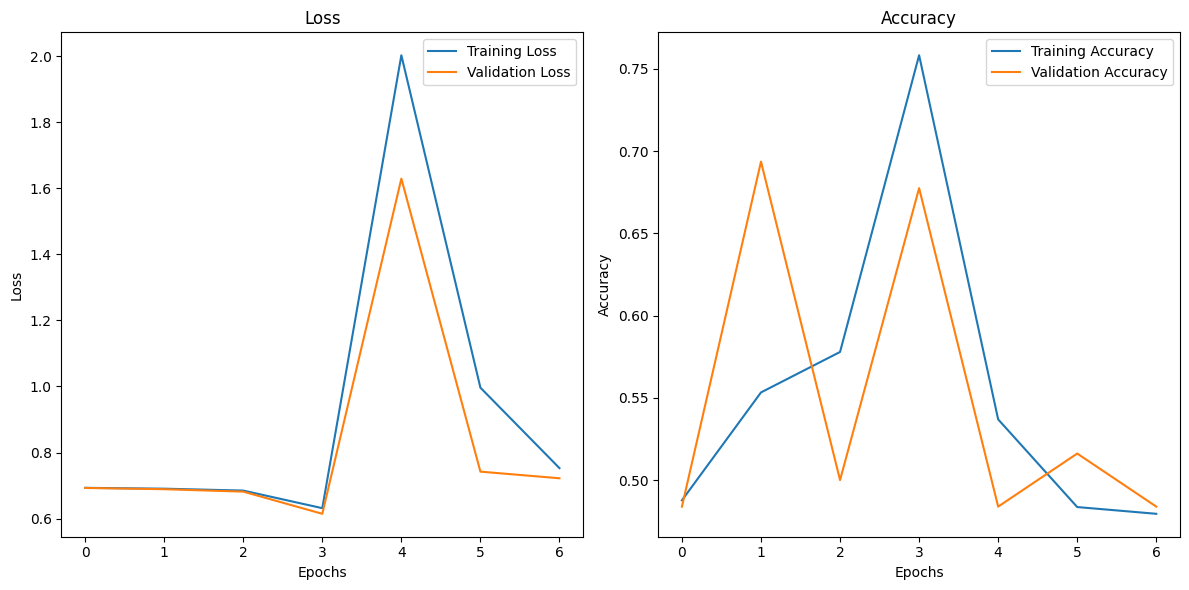

In [52]:
# plot history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Speech Modeling

In [53]:
if type(df['Audio_Features'].iloc[0]) == str:
    df['Features'] = df['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
    
X = np.stack(df['Audio_Features'].values)
print(X.shape)
X = X.reshape(-1,16,16)
y = df['PHQ_Binary'].values
print(X.shape, y.shape)

(306, 1, 1, 256)
(306, 16, 16) (306,)


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_audio = X_train

(244, 16, 16) (62, 16, 16) (244,) (62,)


In [55]:

model = Sequential()
model.add(GRU(64, input_shape=(16, 16), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))  # output shape (None, 2)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 64)             │        15,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,890 (69.88 KB)

 Trainable params: 17,890 (69.88 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
y_train_oh = to_categorical(y_train, num_classes=2)
y_test_oh = to_categorical(y_test, num_classes=2)

# Train the model
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train_oh, epochs=num_epochs, validation_data=(X_test, y_test_oh), callbacks=[early_stop], verbose=2)

Epoch 1/10


8/8 - 4s - 550ms/step - accuracy: 0.4877 - loss: 0.6927 - val_accuracy: 0.4677 - val_loss: 0.6959
Epoch 2/10
8/8 - 0s - 50ms/step - accuracy: 0.5246 - loss: 0.6892 - val_accuracy: 0.4839 - val_loss: 0.6895
Epoch 3/10
8/8 - 0s - 46ms/step - accuracy: 0.6189 - loss: 0.6831 - val_accuracy: 0.5484 - val_loss: 0.6835
Epoch 4/10
8/8 - 0s - 44ms/step - accuracy: 0.6066 - loss: 0.6753 - val_accuracy: 0.5323 - val_loss: 0.6784
Epoch 5/10
8/8 - 0s - 46ms/step - accuracy: 0.5943 - loss: 0.6767 - val_accuracy: 0.6290 - val_loss: 0.6731
Epoch 6/10
8/8 - 0s - 48ms/step - accuracy: 0.6434 - loss: 0.6642 - val_accuracy: 0.6290 - val_loss: 0.6687
Epoch 7/10
8/8 - 1s - 63ms/step - accuracy: 0.6475 - loss: 0.6609 - val_accuracy: 0.6935 - val_loss: 0.6629
Epoch 8/10
8/8 - 0s - 62ms/step - accuracy: 0.6598 - loss: 0.6538 - val_accuracy: 0.6613 - val_loss: 0.6574
Epoch 9/10
8/8 - 0s - 36ms/step - accuracy: 0.6434 - loss: 0.6450 - val_accuracy: 0.6452 - val_loss: 0.6523
Epoch 10/10
8/8 - 0s - 45ms/step - acc

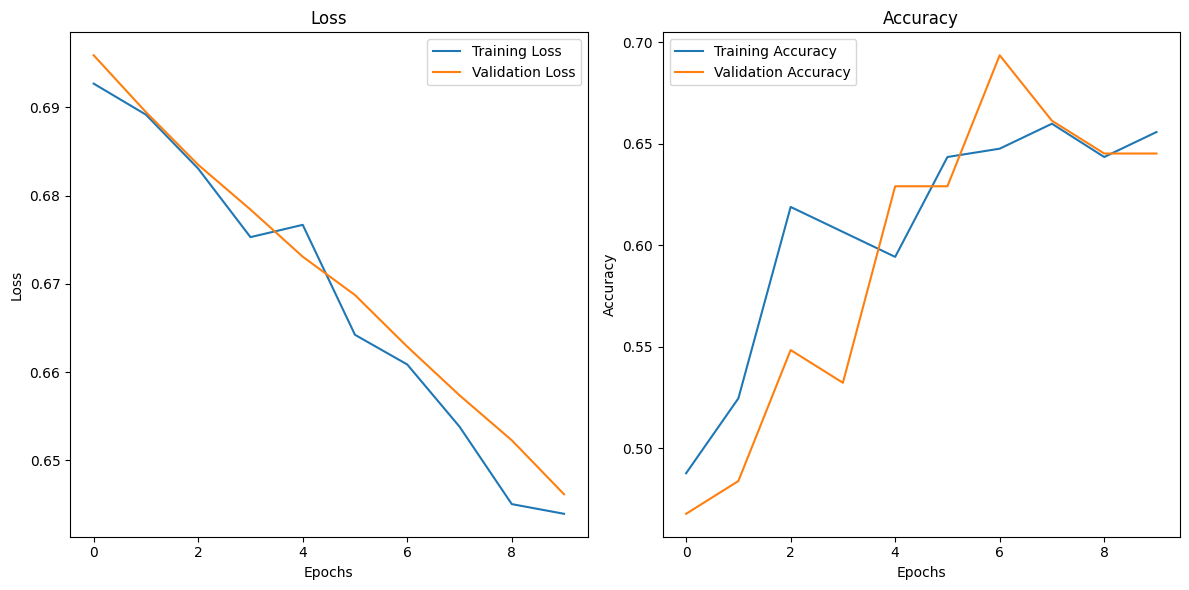

In [57]:
# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Combine

In [58]:
# Text branch
text_input = Input(shape=(max_len,), name='text_input')
x = Embedding(vocab_size, embedding_dim, input_length=max_len)(text_input)
x = Bidirectional(LSTM(n_lstm, return_sequences=False))(x)
x = Dropout(drop)(x)

# Audio (or other) branch
audio_input = Input(shape=(16, 16), name='audio_input')
y = GRU(64, return_sequences=False)(audio_input)
y = Dropout(0.3)(y)
y = Dense(32, activation='relu')(y)
y = Dropout(0.3)(y)

# Fusion
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(2, activation='softmax')(z)

# Final model
fusion_model = Model(inputs=[text_input, audio_input], outputs=output)
fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

fusion_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 16, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 4611)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 64)        │     15,744 │ audio_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 4611, 16)  │    131,920 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ gru_4[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 256)       │    148,480 │ embedding_5[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ bidirectional_5[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 32)        │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 288)       │          0 │ dropout_14[0][0], │
│ (Concatenate)       │                   │            │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     18,496 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 2)         │        130 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 316,850 (1.21 MB)

 Trainable params: 316,850 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
X_text = df['Text']

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_text)
X_text_seq = tokenizer.texts_to_sequences(X_text)

# Pad sequences
X_text_pad = pad_sequences(X_text_seq, maxlen=max_len, padding='post', truncating='post')

if type(df['Audio_Features'].iloc[0]) == str:
    df['Audio_Features'] = df['Audio_Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
    
X_audio = np.stack(df['Audio_Features'].values)
X_audio = X_audio.reshape(-1,16,16)

y = df['PHQ_Binary'].values
y_cat = to_categorical(y, num_classes=2) 

In [72]:
history = fusion_model.fit([X_text_pad, X_audio], y_cat, epochs=10, batch_size=32, validation_split=0.2)

## save model
fusion_model.save('/home/smrutibiswal/Research/SpeechText/fusion_model.h5')


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 1.0000 - loss: 3.4866e-05 - val_accuracy: 0.6290 - val_loss: 3.1037
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 1.0000 - loss: 4.3277e-05 - val_accuracy: 0.6290 - val_loss: 3.1389
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 1.0000 - loss: 1.9617e-05 - val_accuracy: 0.6290 - val_loss: 3.1709
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 1.0000 - loss: 2.1021e-04 - val_accuracy: 0.6129 - val_loss: 3.1880
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 1.0000 - loss: 4.3928e-05 - val_accuracy: 0.6129 - val_loss: 3.2002
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 1.0000 - loss: 4.4560e-05 - val_accuracy: 0.6129 - val_loss: 3.2451
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 1.0000 - loss: 1.9651e-05 - val_accuracy: 0.6129 - val_loss: 3.2780
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 1.0000 - loss: 2.7012e-05 - val_accuracy: 0.

In [73]:
# print accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = fusion_model.predict([X_text_pad, X_audio])
y_pred_classes = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y, y_pred_classes))
print("Precision:", precision_score(y, y_pred_classes))
print("Recall:", recall_score(y, y_pred_classes))
print("F1 Score:", f1_score(y, y_pred_classes))

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
Accuracy: 0.9215686274509803
Precision: 0.9328859060402684
Recall: 0.9084967320261438
F1 Score: 0.9205298013245033


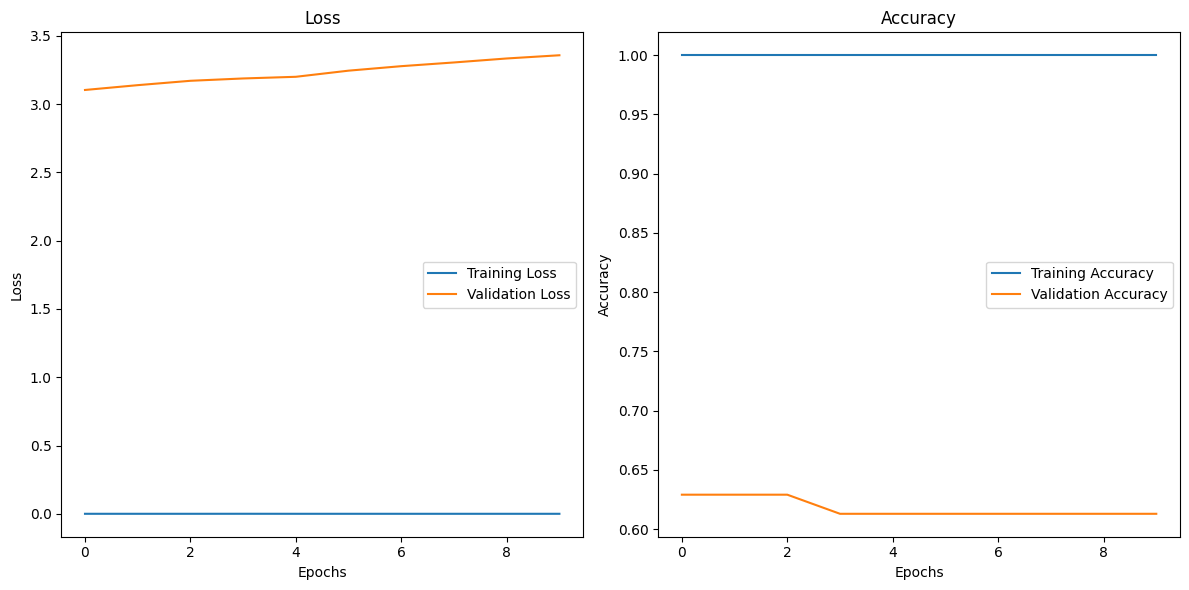

In [74]:
# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()  

Epoch 1/50
8/8 - 43s - 5s/step - accuracy: 1.0000 - loss: 4.7535e-05 - val_accuracy: 0.6290 - val_loss: 3.3861
Epoch 2/50
8/8 - 44s - 6s/step - accuracy: 1.0000 - loss: 2.7345e-05 - val_accuracy: 0.6290 - val_loss: 3.4120
Epoch 3/50
8/8 - 43s - 5s/step - accuracy: 1.0000 - loss: 1.0881e-05 - val_accuracy: 0.6290 - val_loss: 3.4317
Epoch 4/50
8/8 - 44s - 5s/step - accuracy: 1.0000 - loss: 2.5914e-05 - val_accuracy: 0.6290 - val_loss: 3.4529
Epoch 5/50
8/8 - 44s - 6s/step - accuracy: 1.0000 - loss: 2.5028e-05 - val_accuracy: 0.6290 - val_loss: 3.4810
Epoch 6/50
8/8 - 45s - 6s/step - accuracy: 1.0000 - loss: 1.9072e-05 - val_accuracy: 0.6290 - val_loss: 3.5091
Epoch 7/50
8/8 - 45s - 6s/step - accuracy: 1.0000 - loss: 1.1422e-05 - val_accuracy: 0.6452 - val_loss: 3.5311
Epoch 8/50
8/8 - 45s - 6s/step - accuracy: 1.0000 - loss: 3.6483e-05 - val_accuracy: 0.6452 - val_loss: 3.5250
Epoch 9/50
8/8 - 45s - 6s/step - accuracy: 1.0000 - loss: 1.3297e-05 - val_accuracy: 0.6452 - val_loss: 3.5301
E

Training completed successfully!
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
Accuracy: 0.9150326797385621
Precision: 0.9205298013245033
Recall: 0.9084967320261438
F1 Score: 0.9144736842105263


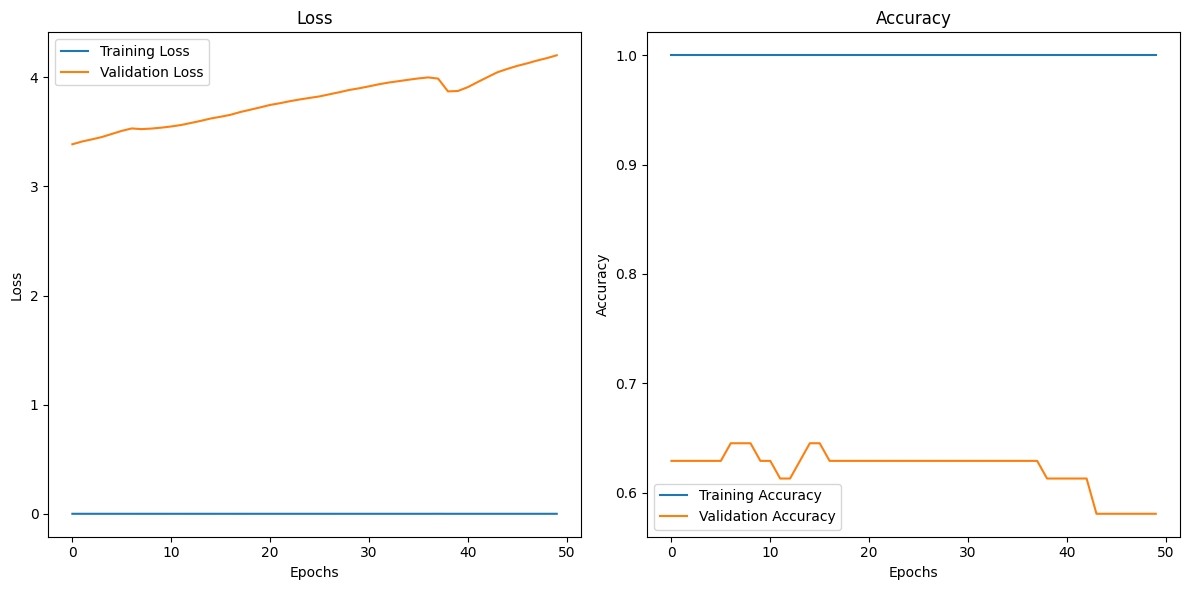

In [75]:
epochs = 50
# early_stop = EarlyStopping(monitor='val_loss', patience=3)
# fusion_model.fit([X_text_pad, X_audio], y_cat, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=2)

history = fusion_model.fit([X_text_pad, X_audio], y_cat, epochs=epochs, batch_size=32, validation_split=0.2, verbose=2)

## save model
fusion_model.save('/home/smrutibiswal/Research/SpeechText/fusion_model.h5')

print("Training completed successfully!")

# print accuracy, precision, recall, f1-score
y_pred = fusion_model.predict([X_text_pad, X_audio])
y_pred_classes = np.argmax(y_pred, axis=1)
print("Accuracy:", accuracy_score(y, y_pred_classes))
print("Precision:", precision_score(y, y_pred_classes))
print("Recall:", recall_score(y, y_pred_classes))
print("F1 Score:", f1_score(y, y_pred_classes))
# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()  